In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
import compressai
import zlib
import numpy as np
import os
from compressai.entropy_models import EntropyBottleneck
from compressai.layers import GDN
from compressai.models import CompressionModel
from compressai.models.utils import conv, deconv
from IPython.display import display

In [3]:
import PIL.Image as Image
def pil_to_pt(img):
    t = transforms.functional.pil_to_tensor(img)
    t = t.to(torch.float)
    t = t/255
    t = t-0.5
    t = t.unsqueeze(0)
    return t

In [2]:
def pt_to_pil(t):
    t = t+0.5
    t = t*255
    t = torch.clamp(t, min=-0.49, max=255.49)
    t = t.round()
    t = t.to(torch.uint8)
    return t

In [4]:
class Network(CompressionModel):
    def __init__(self, N=128):
        super().__init__()
        self.entropy_bottleneck = EntropyBottleneck(N)
        self.encode = nn.Sequential(
            conv(3, N),
            GDN(N),
            conv(N, N),
            GDN(N),
            conv(N, N),
        )

        self.decode = nn.Sequential(
            deconv(N, N),
            GDN(N, inverse=True),
            deconv(N, N),
            GDN(N, inverse=True),
            deconv(N, 3),
        )

    def forward(self, x):
        y = self.encode(x)
        y_hat, y_likelihoods = self.entropy_bottleneck(y)
        x_hat = self.decode(y_hat)
        return x_hat, y_likelihoods

In [5]:
net = Network()
net = net.to("cuda")
checkpoint = torch.load("checkpoint.pth")
net.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [6]:
img = Image.open("kodim05.png");
img.save("kodim05.jpg", "JPEG", quality=5)
jpeg = Image.open("kodim05.jpg");

In [7]:
x = pil_to_pt(img).to("cuda")
z = net.encode(x).round().to(torch.int8).detach().to("cpu").numpy()
original_shape = z.shape
compressed = zlib.compress(z.tobytes(), level=9)
decompressed = zlib.decompress(compressed)
ẑ = np.frombuffer(decompressed, dtype=np.int8)
ẑ = ẑ.reshape(original_shape)
ẑ = torch.tensor(ẑ)
ẑ = ẑ.to("cuda").to(torch.float)
x̂ = net.decode(ẑ).detach().to("cpu")

original image


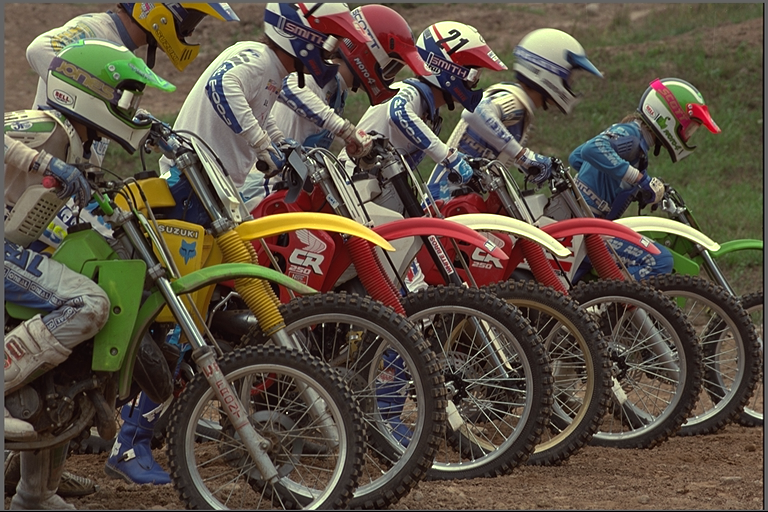

JPEG compression ratio 77.25771170345143


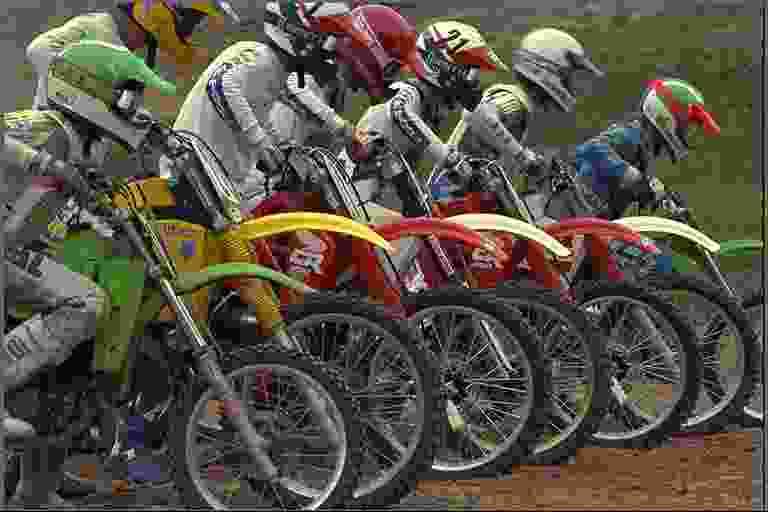

RDAE compression ratio 81.9826256167906


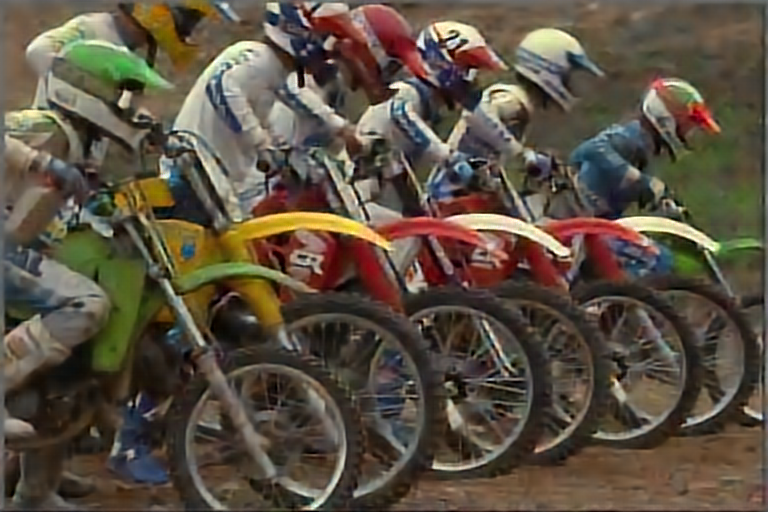

In [8]:
print('original image');
display(img)
print("JPEG compression ratio", (3*512*768)/os.path.getsize('kodim05.jpg'))
display(jpeg);
print("RDAE compression ratio", (3*512*768)/len(compressed))
display(transforms.ToPILImage()(pt_to_pil(x̂)[0]))